Importing all the required libraries and packages

In [ ]:
!pip install tensorflow-addons==0.8.3


     |████████████████████████████████| 1.0 MB 5.2 MB/s 


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import random
import math
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.8.0


Defining Jigsaw function.

In [ ]:
def apply_jigsaw(arr, destinations):
    """Move cells of an image similar to a jigsaw puzzle.
    This function will split the image into ``rows x cols`` cells and
    move each cell to the target index given in `destinations`.
    Added in 0.4.0.
    **Supported dtypes**:
        * ``uint8``: yes; fully tested
        * ``uint16``: yes; fully tested
        * ``uint32``: yes; fully tested
        * ``uint64``: yes; fully tested
        * ``int8``: yes; fully tested
        * ``int16``: yes; fully tested
        * ``int32``: yes; fully tested
        * ``int64``: yes; fully tested
        * ``float16``: yes; fully tested
        * ``float32``: yes; fully tested
        * ``float64``: yes; fully tested
        * ``float128``: yes; fully tested
        * ``bool``: yes; fully tested
    Parameters
    ----------
    arr : ndarray
        Array with at least two dimensions denoting height and width.
    destinations : ndarray
        2-dimensional array containing for each cell the id of the destination
        cell. The order is expected to a flattened c-order, i.e. row by row.
        The height of the image must be evenly divisible by the number of
        rows in this array. Analogous for the width and columns.
    Returns
    -------
    ndarray
        Modified image with cells moved according to `destinations`.
    """
    # pylint complains about unravel_index() here
    # pylint: disable=unbalanced-tuple-unpacking

    nb_rows, nb_cols = destinations.shape[0:2]

    assert arr.ndim >= 2, (
        "Expected array with at least two dimensions, but got %d with "
        "shape %s." % (arr.ndim, arr.sahape))
    assert (arr.shape[0] % nb_rows) == 0, (
        "Expected image height to by divisible by number of rows, but got "
        "height %d and %d rows. Use cropping or padding to modify the image "
        "height or change the number of rows." % (arr.shape[0], nb_rows)
    )
    assert (arr.shape[1] % nb_cols) == 0, (
        "Expected image width to by divisible by number of columns, but got "
        "width %d and %d columns. Use cropping or padding to modify the image "
        "width or change the number of columns." % (arr.shape[1], nb_cols)
    )

    cell_height = arr.shape[0] // nb_rows
    cell_width = arr.shape[1] // nb_cols

    dest_rows, dest_cols = np.unravel_index(
        destinations.flatten(), (nb_rows, nb_cols))

    result = np.zeros_like(arr)
    i = 0
    for source_row in np.arange(nb_rows):
        for source_col in np.arange(nb_cols):
            # TODO vectorize coords computation
            dest_row, dest_col = dest_rows[i], dest_cols[i]

            source_y1 = source_row * cell_height
            source_y2 = source_y1 + cell_height
            source_x1 = source_col * cell_width
            source_x2 = source_x1 + cell_width

            dest_y1 = dest_row * cell_height
            dest_y2 = dest_y1 + cell_height
            dest_x1 = dest_col * cell_width
            dest_x2 = dest_x1 + cell_width

            source = arr[source_y1:source_y2, source_x1:source_x2]
            result[dest_y1:dest_y2, dest_x1:dest_x2] = source

            i += 1

    return result

In [ ]:
def generate_jigsaw_destinations(nb_rows, nb_cols, max_steps, seed,
                                 connectivity=4):
    """Generate a destination pattern for :func:`apply_jigsaw`.
    Added in 0.4.0.
    Parameters
    ----------
    nb_rows : int
        Number of rows to split the image into.
    nb_cols : int
        Number of columns to split the image into.
    max_steps : int
        Maximum number of cells that each cell may be moved.
    seed : None or int or imgaug.random.RNG or numpy.random.Generator or numpy.random.BitGenerator or numpy.random.SeedSequence or numpy.random.RandomState
        Seed value or alternatively RNG to use.
        If ``None`` the global RNG will be used.
    connectivity : int, optional
        Whether a diagonal move of a cell counts as one step
        (``connectivity=8``) or two steps (``connectivity=4``).
    Returns
    -------
    ndarray
        2-dimensional array containing for each cell the id of the target
        cell.
    """
    assert connectivity in (4, 8), (
        "Expected connectivity of 4 or 8, got %d." % (connectivity,))
    random_state = np.random.default_rng(42)
    steps = random_state.integers(0, max_steps, size=(nb_rows, nb_cols),
                                  endpoint=True)
    directions = random_state.integers(0, connectivity,
                                       size=(nb_rows, nb_cols, max_steps),
                                       endpoint=False)
    destinations = np.arange(nb_rows*nb_cols).reshape((nb_rows, nb_cols))

    for step in np.arange(max_steps):
        directions_step = directions[:, :, step]

        for y in np.arange(nb_rows):
            for x in np.arange(nb_cols):
                if steps[y, x] > 0:
                    y_target, x_target = {
                        0: (y-1, x+0),
                        1: (y+0, x+1),
                        2: (y+1, x+0),
                        3: (y+0, x-1),
                        4: (y-1, x-1),
                        5: (y-1, x+1),
                        6: (y+1, x+1),
                        7: (y+1, x-1)
                    }[directions_step[y, x]]
                    y_target = max(min(y_target, nb_rows-1), 0)
                    x_target = max(min(x_target, nb_cols-1), 0)

                    target_steps = steps[y_target, x_target]
                    if (y, x) != (y_target, x_target) and target_steps >= 1:
                        source_dest = destinations[y, x]
                        target_dest = destinations[y_target, x_target]
                        destinations[y, x] = target_dest
                        destinations[y_target, x_target] = source_dest

                        steps[y, x] -= 1
                        steps[y_target, x_target] -= 1

    return destinations

Importing Fashion Dataset .

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


4431872/4422102 [==============================] - 0s 0us/step


Adding one new dimension to train and test images for AlexNet model.

In [ ]:
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

Converting train and test labels into one hot encoded array because categoricalcrossentropy loss function demands it.

In [ ]:
train_labels = np.array(train_labels)
new_labels= np.zeros((train_labels.size, train_labels.max()+1))
new_labels[np.arange(train_labels.size),train_labels] = 1

In [ ]:
test_labels = np.array(test_labels)
new_test_labels= np.zeros((test_labels.size, test_labels.max()+1))
new_test_labels[np.arange(test_labels.size),test_labels] = 1

AlexNet model for Unaugmented images.

In [ ]:
model = tf.keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(28,28,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same"),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same"),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same"),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])


AlexNet model for Augmented images.

In [ ]:
model_jig = tf.keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(28,28,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same"),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),padding="same"),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same"),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])


Applying Jigsaw operation on imported train dataset and storing it.

In [ ]:
def factor(r,c):

 ''' Takes integer row and column
     returns list of factors of row and col, including the number
 '''
 row=[]
 col=[]
 
 i = 1
 while(i <= int(math.sqrt(r))):
      if ( r % i == 0):
        if (int( r/i) == i):
          row.append(i)
        else:
          if (i == 1):
            row.append(int(r/i))
          else:
            row.append(i)
            row.append(int(r/i))
      i = i + 1

 j = 1
 while(j <= int(math.sqrt(c))):
      if ( c % j == 0):
        if (int(c/j) == j):
          col.append(j)
        else:
          if (j == 1):
            col.append(int(c/j))
          else:
            col.append(j)
            col.append(int(c/j))
      j = j + 1

 return row,col     



In [ ]:
destinations=[]
roww=[2,7,4,14,28]
coll=[2,7,4,14,28]
r,c=factor(random.choice(roww),random.choice(coll))
for i in r:
  for j in c:
    destinations.append(generate_jigsaw_destinations(i,j,5,42))

In [ ]:
destinations = np.array(destinations)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
des_shape=int(len(destinations))

In [ ]:
print(des_shape)

5


In [ ]:
x_train_jigg=[]
train_labels_jigg=[]

for img in train_images[:40000]:
  destination_no= random.randint(0,des_shape-1)
  x_train_jigg.append(apply_jigsaw(img,destinations[destination_no]))

x_train_jigg=np.array(x_train_jigg)   
x_train_jig=np.concatenate((x_train_jigg,train_images))  

for label in new_labels[:40000]:
  train_labels_jigg.append(np.array(label))


train_labels_jigg=np.array(train_labels_jigg)
train_labels_jig=np.concatenate((train_labels_jigg,new_labels)) 


Number of images before Data Augmentation.

In [ ]:
train_images.shape

(60000, 28, 28, 1)

Number of images after Data Augmentation.

In [ ]:
x_train_jig.shape

(100000, 28, 28, 1)

Defining a loss function for training using losses.CategoricalCrossentropy, which takes one hot encoded array and returns a scalar loss for each example.

In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()

Compiling Neural Network Model for Unaugmented images.

In [ ]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tfa.metrics.F1Score(num_classes=2, average="micro"),tf.keras.metrics.SpecificityAtSensitivity(0.5)])

Compiling Neural Network Model for Augmented images.

In [ ]:
model_jig.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tfa.metrics.F1Score(num_classes=2, average="micro"),tf.keras.metrics.SpecificityAtSensitivity(0.5)])

Using the Model.fit method to adjust the model parameters and minimize the loss for unaugmented images model.

In [ ]:
history = model.fit(train_images, new_labels, epochs=10, validation_data=(test_images,new_test_labels))

Epoch 1/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.6961 - accuracy: 0.7690 - recall: 0.7051 - precision: 0.8367 - f1_score: 0.7690 - specificity_at_sensitivity: 0.9962

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


1875/1875 [==============================] - 43s 15ms/step - loss: 0.6959 - accuracy: 0.7690 - recall: 0.7051 - precision: 0.8367 - f1_score: 0.7690 - specificity_at_sensitivity: 0.9962 - val_loss: 0.6288 - val_accuracy: 0.7833 - val_recall: 0.7555 - val_precision: 0.8191 - val_f1_score: 0.7833 - val_specificity_at_sensitivity: 0.9968
Epoch 2/10
1875/1875 [==============================] - 25s 14ms/step - loss: 0.5684 - accuracy: 0.8230 - recall: 0.7765 - precision: 0.8685 - f1_score: 0.8230 - specificity_at_sensitivity: 0.9982 - val_loss: 0.4753 - val_accuracy: 0.8415 - val_recall: 0.8110 - val_precision: 0.8735 - val_f1_score: 0.8415 - val_specificity_at_sensitivity: 0.9987
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.4767 - accuracy: 0.8461 - recall: 0.8080 - precision: 0.8840 - f1_score: 0.8461 - specificity_at_sensitivity: 0.9989 - val_loss: 0.4424 - val_accuracy: 0.8380 - val_recall: 0.8067 - val_precision: 0.8739 - val_f1_score: 0.8380 - val_sp

The Model.evaluate method checks the models performance on "Test-set"

In [ ]:
model.evaluate(test_images,new_test_labels)

 22/313 [=>............................] - ETA: 2s - loss: 0.3463 - accuracy: 0.8750 - recall: 0.8551 - precision: 0.9053 - f1_score: 0.8750 - specificity_at_sensitivity: 0.9994

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


313/313 [==============================] - 2s 7ms/step - loss: 0.4159 - accuracy: 0.8783 - recall: 0.8583 - precision: 0.9024 - f1_score: 0.8783 - specificity_at_sensitivity: 0.9995


[0.41590264439582825,
 0.8783000111579895,
 0.858299970626831,
 0.9024287462234497,
 0.8782999515533447,
 0.9995333552360535]

Using the Model.fit method to adjust the model parameters and minimize the loss for Augmented images model.

In [ ]:
history_jig = model_jig.fit(x_train_jig,train_labels_jig, epochs=10, validation_data=(test_images,new_test_labels))

Epoch 1/10
3125/3125 [==============================] - ETA: 0s - loss: 0.7023 - accuracy: 0.7655 - recall_1: 0.6972 - precision_1: 0.8338 - f1_score: 0.7655 - specificity_at_sensitivity_1: 0.9960

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


3125/3125 [==============================] - 43s 13ms/step - loss: 0.7023 - accuracy: 0.7655 - recall_1: 0.6972 - precision_1: 0.8338 - f1_score: 0.7655 - specificity_at_sensitivity_1: 0.9960 - val_loss: 0.5919 - val_accuracy: 0.8018 - val_recall_1: 0.7735 - val_precision_1: 0.8403 - val_f1_score: 0.8018 - val_specificity_at_sensitivity_1: 0.9978
Epoch 2/10
3125/3125 [==============================] - 42s 13ms/step - loss: 0.5311 - accuracy: 0.8249 - recall_1: 0.7777 - precision_1: 0.8682 - f1_score: 0.8249 - specificity_at_sensitivity_1: 0.9983 - val_loss: 0.4097 - val_accuracy: 0.8511 - val_recall_1: 0.8244 - val_precision_1: 0.8844 - val_f1_score: 0.8511 - val_specificity_at_sensitivity_1: 0.9992
Epoch 3/10
3125/3125 [==============================] - 41s 13ms/step - loss: 0.4444 - accuracy: 0.8474 - recall_1: 0.8117 - precision_1: 0.8808 - f1_score: 0.8474 - specificity_at_sensitivity_1: 0.9990 - val_loss: 0.4363 - val_accuracy: 0.8454 - val_recall_1: 0.8175 - val_precision_1: 0.87

In [ ]:
model_jig.evaluate(test_images,new_test_labels)

 22/313 [=>............................] - ETA: 2s - loss: 0.3635 - accuracy: 0.8849 - recall_1: 0.8636 - precision_1: 0.9075 - f1_score: 0.8849 - specificity_at_sensitivity_1: 0.9992

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2034: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


313/313 [==============================] - 3s 9ms/step - loss: 0.3342 - accuracy: 0.8814 - recall_1: 0.8652 - precision_1: 0.9016 - f1_score: 0.8814 - specificity_at_sensitivity_1: 0.9996


[0.3341737985610962,
 0.8813999891281128,
 0.8651999831199646,
 0.9016256928443909,
 0.8813999891281128,
 0.9996111392974854]

Plotting graphs of different metrics.

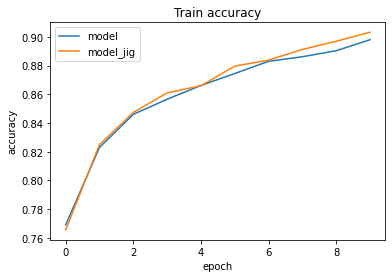

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history_jig.history['accuracy'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['model','model_jig'], loc='upper left')
plt.show()

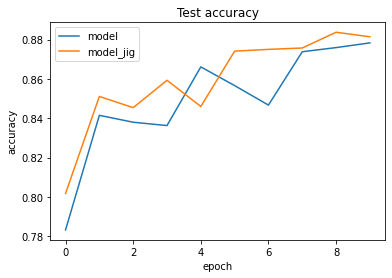

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history_jig.history['val_accuracy'])
plt.title('Test accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['model','model_jig'], loc='upper left')
plt.show()

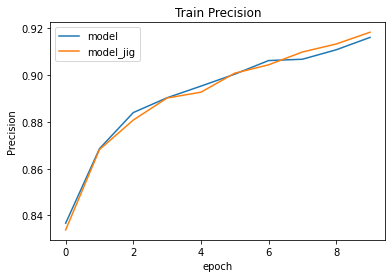

In [ ]:
plt.plot(history.history['precision'])
plt.plot(history_jig.history['precision_1'])
plt.title('Train Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['model','model_jig'], loc='upper left')
plt.show()

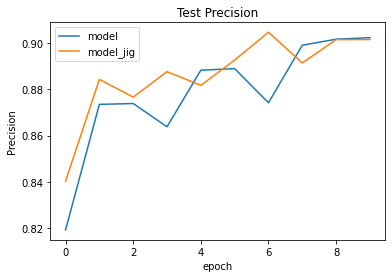

In [ ]:
plt.plot(history.history['val_precision'])
plt.plot(history_jig.history['val_precision_1'])
plt.title('Test Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['model','model_jig'], loc='upper left')
plt.show()

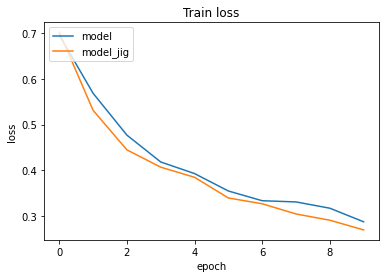

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history_jig.history['loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['model', 'model_jig'], loc='upper left')
plt.show()

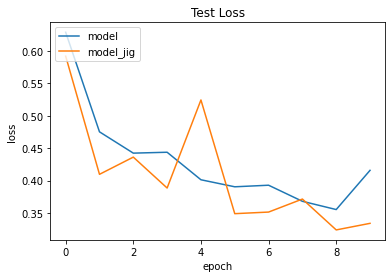

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history_jig.history['val_loss'])
plt.title('Test Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['model', 'model_jig'], loc='upper left')
plt.show()

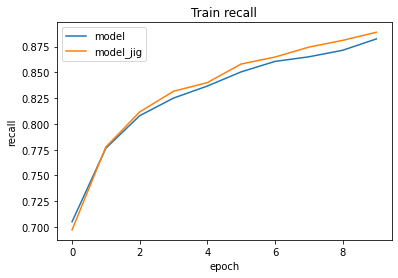

In [ ]:
plt.plot(history.history['recall'])
plt.plot(history_jig.history['recall_1'])
plt.title('Train recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['model', 'model_jig'], loc='upper left')
plt.show()

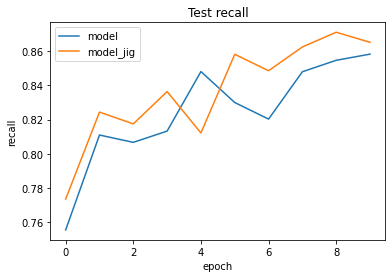

In [ ]:
plt.plot(history.history['val_recall'])
plt.plot(history_jig.history['val_recall_1'])
plt.title('Test recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['model', 'model_jig'], loc='upper left')
plt.show()

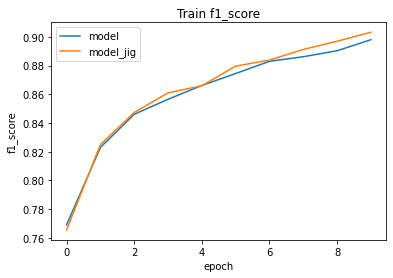

In [ ]:
plt.plot(history.history['f1_score'])
plt.plot(history_jig.history['f1_score'])
plt.title('Train f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['model', 'model_jig'], loc='upper left')
plt.show()

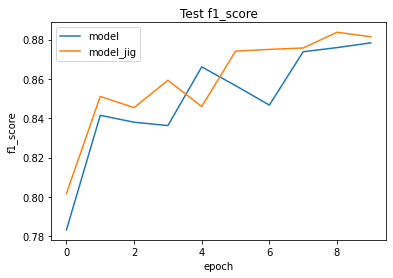

In [ ]:
plt.plot(history.history['val_f1_score'])
plt.plot(history_jig.history['val_f1_score'])
plt.title('Test f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['model', 'model_jig'], loc='upper left')
plt.show()

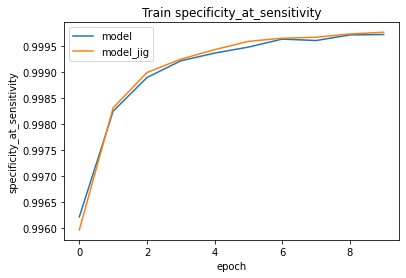

In [ ]:
plt.plot(history.history['specificity_at_sensitivity'])
plt.plot(history_jig.history['specificity_at_sensitivity_1'])
plt.title('Train specificity_at_sensitivity')
plt.ylabel('specificity_at_sensitivity')
plt.xlabel('epoch')
plt.legend(['model', 'model_jig'], loc='upper left')
plt.show()

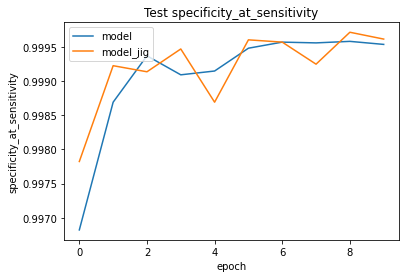

In [ ]:
plt.plot(history.history['val_specificity_at_sensitivity'])
plt.plot(history_jig.history['val_specificity_at_sensitivity_1'])
plt.title('Test specificity_at_sensitivity')
plt.ylabel('specificity_at_sensitivity')
plt.xlabel('epoch')
plt.legend(['model', 'model_jig'], loc='upper left')
plt.show()

Making Predictions for first 25 test images.


In [ ]:
predictions = model_jig.predict(test_images[:25])

In [ ]:
predictions.shape

(25, 10)

Storing the predicted values in class_id.

In [ ]:
class_id = np.argmax(predictions,axis= 1)

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
class_predicted_name=[]
for id in class_id:
    class_predicted_name.append(class_names[id])

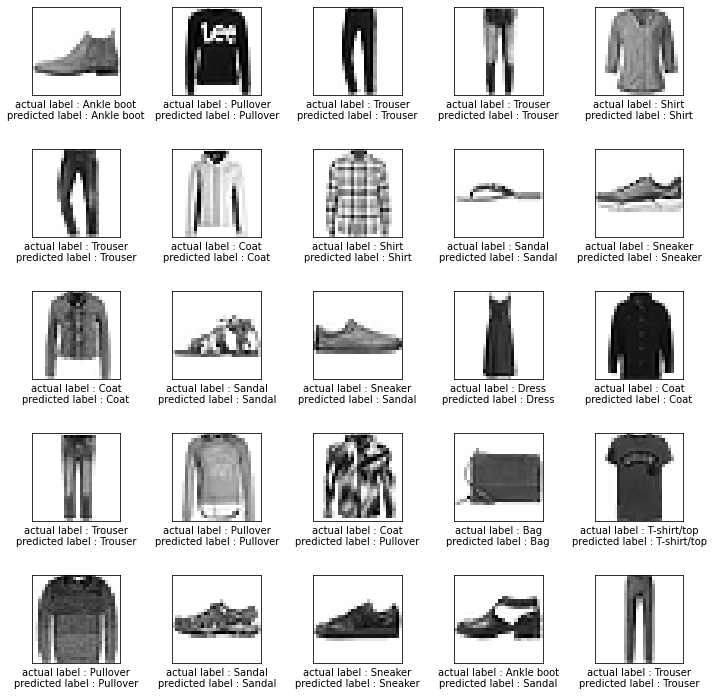

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i].squeeze(), cmap=plt.cm.binary)
    plt.xlabel('actual label : '+ class_names[test_labels[i]]+'\n'+'predicted label : '+ class_predicted_name[i])
    
plt.show()

Example of augmentation variation in few images.

In [ ]:
row = [2,4,7,14,28]
col = [2,4,7,14,28]
dest=[]
for i in row:
  for j in col:
    dest.append(generate_jigsaw_destinations(i,j,5,42))

In [ ]:
all_jig_pattern=[]
for i in range(25):
  all_jig_pattern.append(apply_jigsaw(train_images[6],dest[i]))

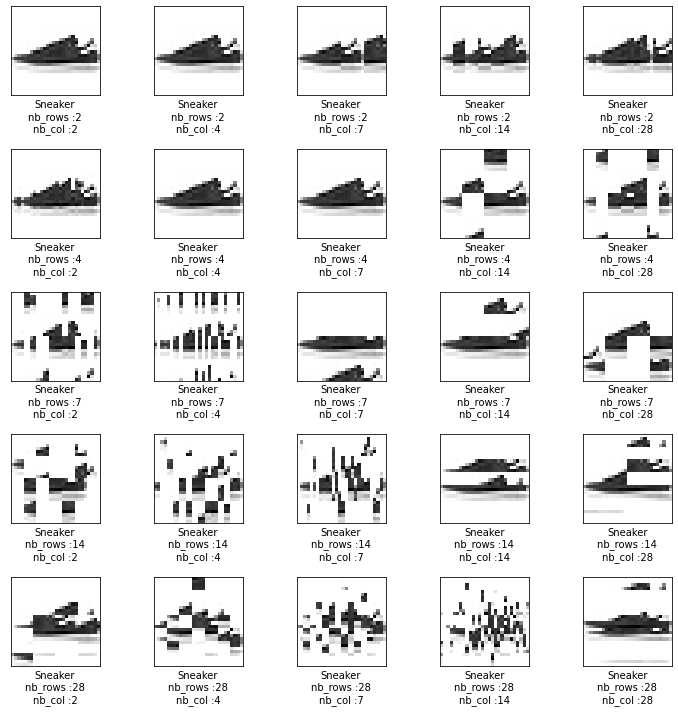

In [ ]:
ro=[2,2,2,2,2,4,4,4,4,4,7,7,7,7,7,14,14,14,14,14,28,28,28,28,28]
co=[2,4,7,14,28,2,4,7,14,28,2,4,7,14,28,2,4,7,14,28,2,4,7,14,28]
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(all_jig_pattern[i].squeeze(), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[6]]+'\n'+'nb_rows :'+str(ro[i])+'\n'+'nb_col :'+str(co[i]))
    
plt.show()

In [ ]:
all_jig_pattern1=[]
for i in range(25):
  all_jig_pattern1.append(apply_jigsaw(train_images[20],dest[i]))

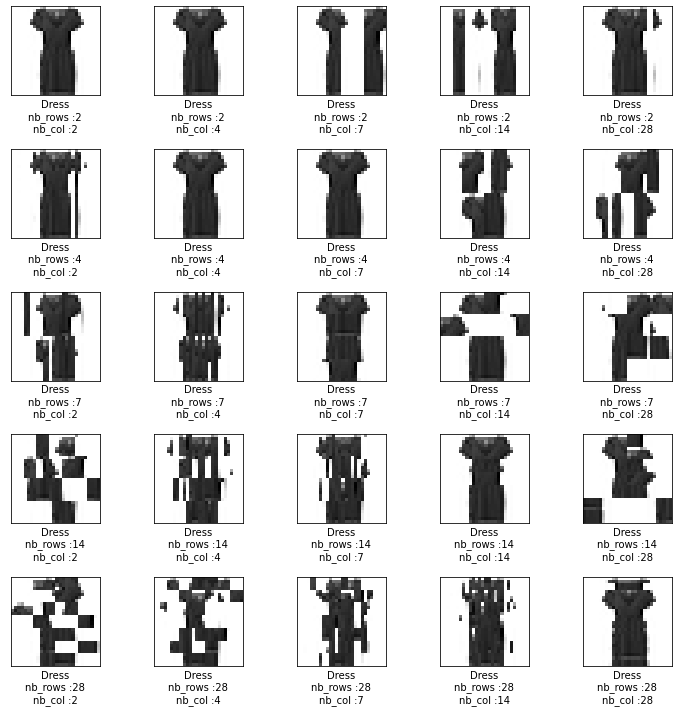

In [ ]:
ro=[2,2,2,2,2,4,4,4,4,4,7,7,7,7,7,14,14,14,14,14,28,28,28,28,28]
co=[2,4,7,14,28,2,4,7,14,28,2,4,7,14,28,2,4,7,14,28,2,4,7,14,28]
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(all_jig_pattern1[i].squeeze(), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[20]]+'\n'+'nb_rows :'+str(ro[i])+'\n'+'nb_col :'+str(co[i]))
    
plt.show()